In [2]:
# Standard Dependencies
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

# Tensorflow Dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, InSput, Flatten
import tensorflow as tf

In [3]:

# Avoiding OOM Errors for GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Folder Structure
Pos_Path = os.path.join("data", "positive")
Neg_Path = os.path.join("data", "negative")
Anc_Path = os.path.join("data", "anchor")

In [5]:
os.makedirs(Pos_Path)
os.makedirs(Neg_Path)
os.makedirs(Anc_Path)

In [6]:
!tar -xf lfw.tgz

In [7]:
# Movw LFW data to data/neg
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        EX_PATH = os.path.join("lfw", directory, file)
        NEW_PATH = os.path.join(Neg_Path, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
# Connect Webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize Frame
    frame = frame[120:120+250, 250: 250+250, :]
    
    # Collect Anchors
    if cv2.waitKey(1) & 0XFF == ord("a"):
        # Creating Unique filepath
        imgname = os.path.join(Anc_Path, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord("p"):
        # Creating Unique filepath
        imgname = os.path.join(Pos_Path, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow("Image Collection", frame)
    
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break
# Release webcam        
cap.release()
# Close image
cv2.destroyAllWindows()

In [9]:
anchor = tf.data.Dataset.list_files(Anc_Path+"\*.jpg").take(300)
positive = tf.data.Dataset.list_files(Pos_Path+"\*.jpg").take(300)
negative = tf.data.Dataset.list_files(Neg_Path+"\*.jpg").take(300)

In [10]:
# Preprocessing
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img /255.0
    return img    

In [11]:
# Creating Labelled Dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [12]:
samples = data.as_numpy_iterator()

In [13]:
def preprocess_twins(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [14]:
# Dataloader Pipeline
data = data.map(preprocess_twins)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training Partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [16]:
# Embedding Layer
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)
    
    #Second Block
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)
    
    #Third Block
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c2)
    
    # Final Embedding Layer
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [17]:
embedding = make_embedding()

In [18]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 256)       524544    
_________________________________________________________________
flatten (Flatten)            (None, 73984)             0 

In [19]:
# Siamese L1 Distance Class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # Similarity Clarification
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [20]:
l1 = L1Dist()

In [21]:
# Siamese Model
def make_siamese_model():
    
    # Anchor Image
    input_image = Input(name="input_img", shape=(100, 100, 3))
    
    # Validation Image
    validation_image = Input(name="validation_img", shape=(100, 100, 3))
    
    # Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [22]:
siamese_model = make_siamese_model()

In [23]:

siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         303987904   input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [24]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [25]:
opt = tf.keras.optimizers.Adam(1e-4)

In [26]:
# Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [27]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [28]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [29]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [30]:
EPOCHS = 50

In [31]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 31s 3s/step
0.50886005 0.0 0.0

 Epoch 2/50
2/2 [==============================] - 26s 2s/step
1.0504903 0.0 0.0

 Epoch 3/50
2/2 [==============================] - 25s 2s/step
0.29203856 0.8 1.0

 Epoch 4/50
2/2 [==============================] - 25s 3s/step
0.13794409 0.8333333 1.0

 Epoch 5/50
2/2 [==============================] - 26s 3s/step
0.005071125 0.8333333 1.0

 Epoch 6/50
2/2 [==============================] - 27s 2s/step
0.03551115 1.0 1.0

 Epoch 7/50
2/2 [==============================] - 25s 2s/step
0.012230438 1.0 1.0

 Epoch 8/50
2/2 [==============================] - 25s 3s/step
0.08519327 1.0 1.0

 Epoch 9/50
2/2 [==============================] - 27s 3s/step
0.010482463 1.0 1.0

 Epoch 10/50
2/2 [==============================] - 26s 3s/step
0.1796262 1.0 1.0

 

In [32]:
from tensorflow.keras.metrics import Precision, Recall

In [33]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [34]:
y_hat = siamese_model.predict([test_input, test_val])
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 1, 1]

In [35]:
y_true

array([0., 0., 0., 0., 1., 1., 1.], dtype=float32)

In [36]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [37]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [38]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


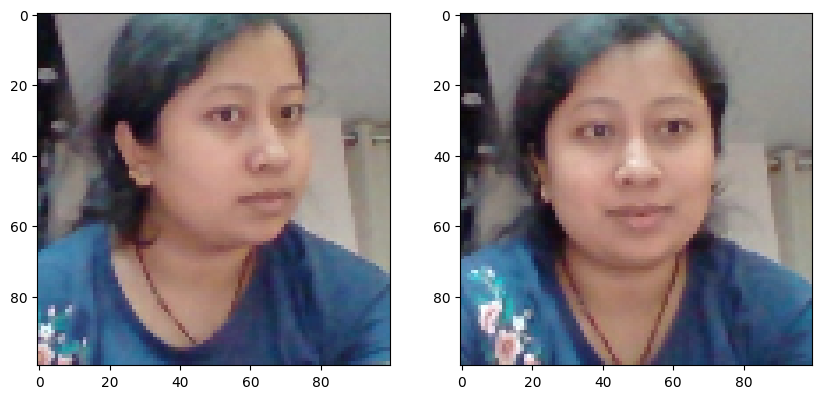

In [47]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [46]:
siamese_model.save('siamesemodelv2.h5')

In [48]:
L1Dist

__main__.L1Dist

In [49]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [50]:

# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[9.9982315e-01],
       [2.2500037e-08],
       [3.9466153e-07],
       [9.9998772e-01],
       [5.5817835e-09],
       [9.9830544e-01],
       [3.6202382e-06]], dtype=float32)

In [44]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         303987904   input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     